<a href="https://colab.research.google.com/github/krishnafitech/Machine-Learning-Collection/blob/master/LedgerMindAI_Issue_4_Workforce_Attrition_%26_Cost_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


STEP 1 — Upload the Kaggle file into


In [1]:
from google.colab import files
uploaded = files.upload()


Saving WA_Fn-UseC_-HR-Employee-Attrition.csv to WA_Fn-UseC_-HR-Employee-Attrition.csv


In [2]:
import pandas as pd

data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
data.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


STEP 2 — Clean + Prepare Dataset (simple, FP&A-ready)

In [3]:
# Step 2: Clean + Prepare IBM HR Analytics dataset

df = data.copy()

# Drop employee identifier columns (no predictive value)
cols_to_drop = ["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"]
df = df.drop(cols_to_drop, axis=1)

# Convert Attrition Yes/No to 1/0
df["Attrition"] = df["Attrition"].map({"Yes": 1, "No": 0})

# Identify categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

# One-hot encode all categorical fields
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Split features and target
X = df.drop("Attrition", axis=1)
y = df["Attrition"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

df.shape, X_train.shape, X_test.shape


((1470, 45), (1102, 44), (368, 44))

STEP 3 — Fix Class Imbalance (SMOTE)

In [5]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before:", y_train.value_counts().to_dict())
print("After:", y_train_res.value_counts().to_dict())



Before: {0: 924, 1: 178}
After: {0: 924, 1: 924}


STEP 4 — Train Random Forest (simple, clean, accurate).

In [6]:
# Step 4: Train Random Forest on balanced data

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    class_weight=None  # not needed because we used SMOTE
)

rf.fit(X_train_res, y_train_res)

print("Model trained.")


Model trained.


STEP 5 — Evaluate the model: AUC, accuracy, recall, precision

In [7]:
# Step 5: Evaluate the Random Forest model

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # probability of attrition (class 1)

# Metrics
print("AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


AUC Score: 0.7223959190389995

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       309
           1       0.45      0.29      0.35        59

    accuracy                           0.83       368
   macro avg       0.66      0.61      0.63       368
weighted avg       0.80      0.83      0.81       368


Confusion Matrix:
[[288  21]
 [ 42  17]]


STEP 6 — Feature Importance (What drives attrition)

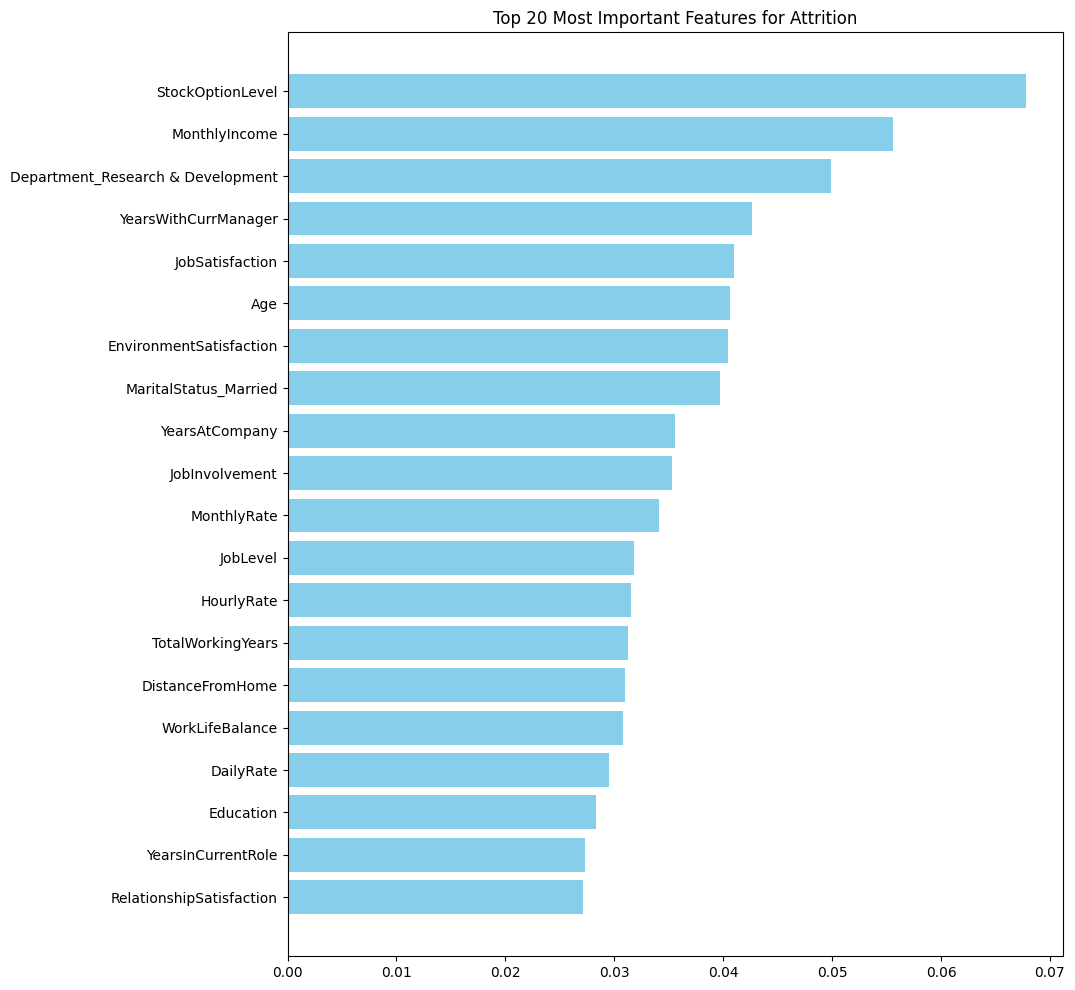

In [8]:
# Step 6: Feature Importance

import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
feature_names = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 12))
plt.title("Top 20 Most Important Features for Attrition")
plt.barh(range(20), importances[indices][:20], color='skyblue')
plt.yticks(range(20), [feature_names[i] for i in indices[:20]])
plt.gca().invert_yaxis()
plt.show()


STEP 7 — Generate Attrition Probability for the Full Roster

In [9]:
# Step 7: Generate attrition probability (risk score) for every employee

full_prob = rf.predict_proba(X)[:, 1]  # probability of class 1 (attrition)

# Attach probabilities back to the original dataset
df_prob = data.copy()
df_prob["Attrition_Prob"] = full_prob

df_prob.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Prob
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,0.765148
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,0.068447
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,0.512797
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,0.324467
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,0.189175


STEP 8 — Monthly Attrition Simulation (12 months)

In [10]:
# Step 8: Simulate attrition month-by-month for 12 months

import numpy as np
import pandas as pd

df_sim = df_prob.copy()

months = 12
monthly_results = []

current_population = df_sim.copy()

for month in range(1, months + 1):

    # Simulate who leaves in this month
    random_prob = np.random.rand(len(current_population))
    will_leave = (random_prob < current_population["Attrition_Prob"]).astype(int)

    leavers = current_population[will_leave == 1]
    stayers = current_population[will_leave == 0]

    monthly_results.append({
        "Month": month,
        "Starting_Headcount": len(current_population),
        "Leavers": len(leavers),
        "Ending_Headcount": len(stayers)
    })

    # Update population (remove leavers)
    current_population = stayers.copy()

# Convert to dataframe
sim_df = pd.DataFrame(monthly_results)
sim_df


,Month,Starting_Headcount,Leavers,Ending_Headcount
0,1,1470,318,1152
1,2,1152,212,940
2,3,940,132,808
3,4,808,92,716
4,5,716,80,636
5,6,636,63,573
6,7,573,51,522
7,8,522,53,469
8,9,469,44,425
9,10,425,50,375


from matplotlib import pyplot as plt
sim_df['Month'].plot(kind='hist', bins=20, title='Month')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
sim_df['Starting_Headcount'].plot(kind='hist', bins=20, title='Starting_Headcount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
sim_df['Leavers'].plot(kind='hist', bins=20, title='Leavers')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
sim_df['Ending_Headcount'].plot(kind='hist', bins=20, title='Ending_Headcount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
sim_df.plot(kind='scatter', x='Month', y='Starting_Headcount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
sim_df.plot(kind='scatter', x='Starting_Headcount', y='Leavers', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
sim_df.plot(kind='scatter', x='Leavers', y='Ending_Headcount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['Starting_Headcount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sim_df.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('Starting_Headcount')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['Leavers']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sim_df.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('Leavers')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['Ending_Headcount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sim_df.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('Ending_Headcount')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Month']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Month'}, axis=1)
              .sort_values('Month', ascending=True))
  xs = counted['Month']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = sim_df.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
sim_df['Month'].plot(kind='line', figsize=(8, 4), title='Month')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
sim_df['Starting_Headcount'].plot(kind='line', figsize=(8, 4), title='Starting_Headcount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
sim_df['Leavers'].plot(kind='line', figsize=(8, 4), title='Leavers')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
sim_df['Ending_Headcount'].plot(kind='line', figsize=(8, 4), title='Ending_Headcount')
plt.gca().spines[['top', 'right']].set_visible(False)

STEP 9 — Payroll Cost Forecast (12 months)

In [11]:
# Step 9: Payroll Cost Forecast based on simulated attrition

df_pay = df_prob.copy()
df_pay["Current"] = 1  # everyone is active at month 0

months = 12
payroll_forecast = []

active_population = df_pay.copy()

for month in range(1, months + 1):

    # simulate attrition again (consistent with previous simulation)
    random_prob = np.random.rand(len(active_population))
    will_leave = (random_prob < active_population["Attrition_Prob"]).astype(int)

    # leavers cost = 0 next month
    leavers = active_population[will_leave == 1]
    stayers = active_population[will_leave == 0]

    # compute payroll cost for current month
    total_cost = stayers["MonthlyIncome"].sum()

    payroll_forecast.append({
        "Month": month,
        "Active_Headcount": len(stayers),
        "Payroll_Cost": total_cost
    })

    # update active population
    active_population = stayers.copy()

payroll_df = pd.DataFrame(payroll_forecast)
payroll_df


,Month,Active_Headcount,Payroll_Cost
0,1,1117,7623927
1,2,953,6637085
2,3,815,5814490
3,4,715,5201861
4,5,629,4634916
5,6,569,4268527
6,7,515,3931576
7,8,468,3625885
8,9,433,3345021
9,10,393,3068240


from matplotlib import pyplot as plt
payroll_df['Month'].plot(kind='hist', bins=20, title='Month')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
payroll_df['Active_Headcount'].plot(kind='hist', bins=20, title='Active_Headcount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
payroll_df['Payroll_Cost'].plot(kind='hist', bins=20, title='Payroll_Cost')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
payroll_df.plot(kind='scatter', x='Month', y='Active_Headcount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
payroll_df.plot(kind='scatter', x='Active_Headcount', y='Payroll_Cost', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['Active_Headcount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = payroll_df.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('Active_Headcount')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['Payroll_Cost']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = payroll_df.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('Payroll_Cost')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Month']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Month'}, axis=1)
              .sort_values('Month', ascending=True))
  xs = counted['Month']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = payroll_df.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
payroll_df['Month'].plot(kind='line', figsize=(8, 4), title='Month')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
payroll_df['Active_Headcount'].plot(kind='line', figsize=(8, 4), title='Active_Headcount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
payroll_df['Payroll_Cost'].plot(kind='line', figsize=(8, 4), title='Payroll_Cost')
plt.gca().spines[['top', 'right']].set_visible(False)

STEP 10 — Combine Attrition + Payroll into One Dashboard Table

In [12]:
# Step 10: Combine attrition simulation + payroll forecast

dashboard_df = sim_df.merge(
    payroll_df,
    on="Month",
    how="left"
)

dashboard_df


,Month,Starting_Headcount,Leavers,Ending_Headcount,Active_Headcount,Payroll_Cost
0,1,1470,318,1152,1117,7623927
1,2,1152,212,940,953,6637085
2,3,940,132,808,815,5814490
3,4,808,92,716,715,5201861
4,5,716,80,636,629,4634916
5,6,636,63,573,569,4268527
6,7,573,51,522,515,3931576
7,8,522,53,469,468,3625885
8,9,469,44,425,433,3345021
9,10,425,50,375,393,3068240


from matplotlib import pyplot as plt
dashboard_df['Month'].plot(kind='hist', bins=20, title='Month')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dashboard_df['Starting_Headcount'].plot(kind='hist', bins=20, title='Starting_Headcount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dashboard_df['Leavers'].plot(kind='hist', bins=20, title='Leavers')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dashboard_df['Ending_Headcount'].plot(kind='hist', bins=20, title='Ending_Headcount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dashboard_df.plot(kind='scatter', x='Month', y='Starting_Headcount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dashboard_df.plot(kind='scatter', x='Starting_Headcount', y='Leavers', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dashboard_df.plot(kind='scatter', x='Leavers', y='Ending_Headcount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
dashboard_df.plot(kind='scatter', x='Ending_Headcount', y='Active_Headcount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['Starting_Headcount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dashboard_df.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('Starting_Headcount')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['Leavers']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dashboard_df.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('Leavers')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['Ending_Headcount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dashboard_df.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('Ending_Headcount')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Month']
  ys = series['Active_Headcount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = dashboard_df.sort_values('Month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Month')
_ = plt.ylabel('Active_Headcount')

from matplotlib import pyplot as plt
dashboard_df['Month'].plot(kind='line', figsize=(8, 4), title='Month')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
dashboard_df['Starting_Headcount'].plot(kind='line', figsize=(8, 4), title='Starting_Headcount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
dashboard_df['Leavers'].plot(kind='line', figsize=(8, 4), title='Leavers')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
dashboard_df['Ending_Headcount'].plot(kind='line', figsize=(8, 4), title='Ending_Headcount')
plt.gca().spines[['top', 'right']].set_visible(False)

Step 11 — Headcount Trend Plot + Payroll Trend Plot

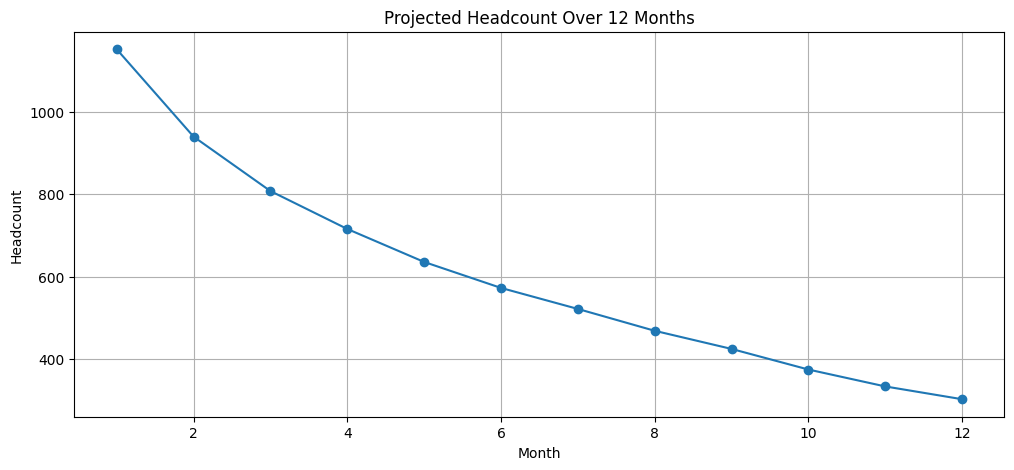

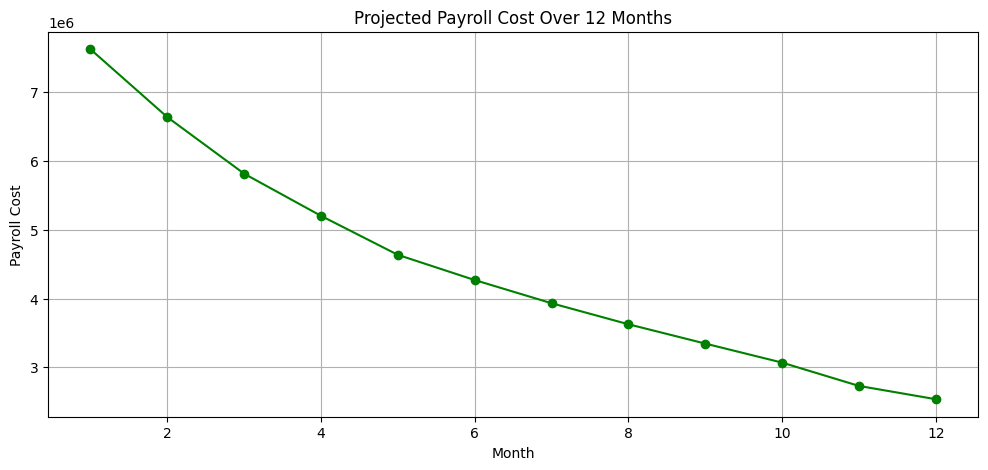

In [13]:
# Step 11: Plot Headcount and Payroll trends

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(dashboard_df["Month"], dashboard_df["Ending_Headcount"], marker='o')
plt.title("Projected Headcount Over 12 Months")
plt.xlabel("Month")
plt.ylabel("Headcount")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(dashboard_df["Month"], dashboard_df["Payroll_Cost"], marker='o', color='green')
plt.title("Projected Payroll Cost Over 12 Months")
plt.xlabel("Month")
plt.ylabel("Payroll Cost")
plt.grid(True)
plt.show()


STEP 12 — Export dashboard + risk scores to CSV (Adaptive-ready)

In [14]:
# Step 12: Export final outputs to CSV files

dashboard_df.to_csv("LedgerMind_Attrition_Payroll_Dashboard.csv", index=False)
df_prob.to_csv("LedgerMind_Employee_Attrition_RiskScores.csv", index=False)

print("Files exported:")
print(" - LedgerMind_Attrition_Payroll_Dashboard.csv")
print(" - LedgerMind_Employee_Attrition_RiskScores.csv")


Files exported:
 - LedgerMind_Attrition_Payroll_Dashboard.csv
 - LedgerMind_Employee_Attrition_RiskScores.csv


In [15]:
from google.colab import files
files.download("LedgerMind_Attrition_Payroll_Dashboard.csv")
files.download("LedgerMind_Employee_Attrition_RiskScores.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>